# Normal distribution 

The simplest model: the Normal distribution. It is used as a basic components in many more complex models.

In [ ]:
using Pkg
Pkg.activate("../");

using LinearAlgebra
using Plots
using Random

import ExpFamilyDistributions
const EFD = ExpFamilyDistributions

using Zygote

using Revise
using BayesianModels

using BasicDataLoaders


# Plotting function
include("plotting.jl");

 Activating environment at `~/GithubRepositories/PPCA/Project.toml`
┌ Info: Precompiling BayesianModels [1400088c-90aa-43b9-ae43-7211fec07595]
└ @ Base loading.jl:1278


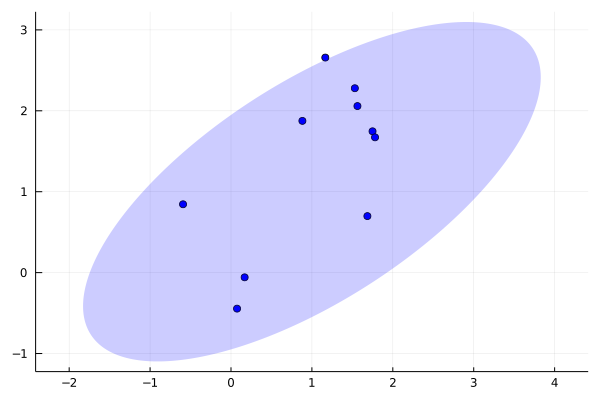

In [3]:
T = Float64
μₓ = T[1, 1] 
Σₓ = T[2 1; 1.0  1.1]

function draw(n, μ, Σ)
    L = cholesky(Σ).L
    [μ + L*randn(T, 2) for i in 1:n] 
end

X = draw(10, μₓ, Σₓ)

p = plot(legend = false, aspect_ratio = 1)
scatter!(getindex.(X, 1), getindex.(X, 2), color = :blue)
plotnormal!(μₓ, Σₓ, σ = 2, color = :blue, linewidth = 0, fillalpha = 0.2)

In [22]:
D = 2
W₀ = Matrix{Float64}(I, D, D)
μ₀ = zeros(D)
Σ₀ = Matrix{Float64}(I, D, D)
pstrength = 1

μ = BayesParameter(EFD.Normal(μ₀, pstrength * Σ₀), 
               EFD.Normal(μ₀, pstrength * Σ₀))

Λ = BayesParameter(EFD.Wishart(W₀, D - 1 + pstrength), 
               EFD.Wishart(W₀, D - 1 + pstrength))


model = BayesianModels.Normal{D}(μ, Λ)

Normal (
BayesParameter{ExpFamilyDistributions.Normal,ExpFamilyDistributions.Normal}BayesParameter{ExpFamilyDistributions.Wishart,ExpFamilyDistributions.Wishart})


In [41]:
model.Λ.μ

4-element Array{Float64,1}:
  2.0
  2.0
  0.0
 -1.1544313298030644

In [38]:
lrate = 0.1
epochs = 1000
batchsize = length(X)

elbos = []#[elbo(model_std, X)]
params = filter(isbayesparam, getparams(model))

for epoch in 1:epochs
    dl = DataLoader(shuffle(X), batchsize = batchsize)
    for batch in dl
        gradstep(∇elbo(model, batch, stats_scale = length(dl); params); lrate)
    end
    push!(elbos, elbo(model, X))
end

plot(elbos, legend = false)

LoadError: type BayesParameter has no field _μ

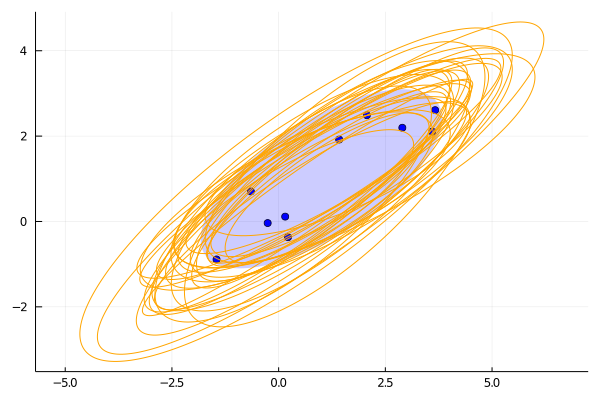

In [21]:
p = plot(legend = false, aspect_ratio = 1)
scatter!(getindex.(X, 1), getindex.(X, 2), color = :blue)
plotnormal!(μₓ, Σₓ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)

μs = EFD.sample(model.μ.posterior, 30)
Σs = [inv(Λₗ) for Λₗ in EFD.sample(model.Λ.posterior, 30)]
for (μ, Σ) in zip(μs, Σs)
    plotnormal!(μ, Σ, σ = 2, color = :orange, linecolor = :orange, fillalpha = 0)
end

p

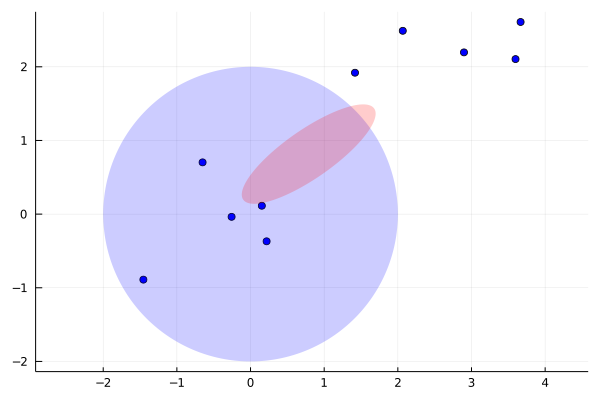

In [23]:
p = plot(legend = false, aspect_ratio = 1)
scatter!(getindex.(X, 1), getindex.(X, 2), color = :blue)
plotnormal!(model.μ.prior.μ, model.μ.prior.Σ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)
plotnormal!(model.μ.posterior.μ, model.μ.posterior.Σ, σ = 2, color = :red, linecolor = :red, linewidth = 0, fillalpha = 0.2)

p